In [23]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

In [40]:
states = np.array([0,1])
actions = np.array([0,1]) #0 = stay , #1 = move
N = 200000 #number of steps
phi = 500 #soft-min parameter
p = 0.01
c = 5
gamma = 0.5
tol_q = 0.1
tol_mu = 0.01
om_q = 0.55
om_mu = 0.85

Q = [[[10, 10], [10,10]]]
mu = [np.array([1/2, 1/2])]
print(mu)
def rhosCalc (count_xa, n):
    rhoQ = 1 / np.pow(1 + count_xa, om_q)
    rhoMu = 1 / np.pow(2 + n, om_mu)
    return { 'q': rhoQ, 'mu': rhoMu }

def env(state, action, mu):
    newS = state
    if random.random() < p:
        newS = (state + action) % 2
    else: 
        newS = (state + action - 1) % 2
    return { "newState": newS,  "cost": state + c * mu[newS]}


def stable_softmin_action(q_values, actions, phi=phi):
    scaled_q = -phi * np.array(q_values)
    
    # 2. Key for Stability: Subtract the maximum of the SCALED values 
    # (This aligns the highest value to 0, preventing overflow in exp)
    z = scaled_q - np.max(scaled_q)
    
    # 3. Calculate weights (probabilities) using vectorized operations
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    probabilities = numerator / denominator
    
    # 4. Check for NaNs (safety check after stability fix)
    if np.isnan(probabilities).any():
        print("Warning: NaNs still present in probabilities. Check input Q_values or phi value.")
        # Handle the error gracefully, maybe by choosing a random action uniformly
        return np.random.choice(actions), probabilities
        
    # 5. Return the chosen action based on the probabilities
    return np.random.choice(actions, p=probabilities), probabilities


[array([0.5, 0.5])]


In [67]:

# initialize count for finding rho_Q (learning rate)
count = [[0, 0],[0,0]]

x = np.random.choice(states, p = mu[0])

# iterate N times
for n in range(N):

    # copy new Q matrix, mu distribution
    Q.append(np.copy(Q[n]))
    mu.append(np.copy(mu[n]))

    # use softmin to choose next action
    a, probs = stable_softmin_action(Q[n + 1][x], actions)

    # update counter for rho calculation
    count[x][a] += 1
    rhos = rhosCalc(count[x][a], n)

    # input state, action, mu into environment
    # and receive new state and cost
    envir = env(x, a, mu[n + 1])

    x = envir["newState"]
    delta_X_n = np.zeros(len(states))
    delta_X_n[x] = 1
    mu[n + 1] += rhos['mu'] * (delta_X_n - mu[n])

    # update Q matrix, current state, mu distribution
    Q[n+1][envir["newState"]][a] += rhos['q'] * (
    envir["cost"] 
    + gamma * np.min(Q[n+1][envir["newState"]]) 
    - Q[n+1][envir["newState"]][a])
    


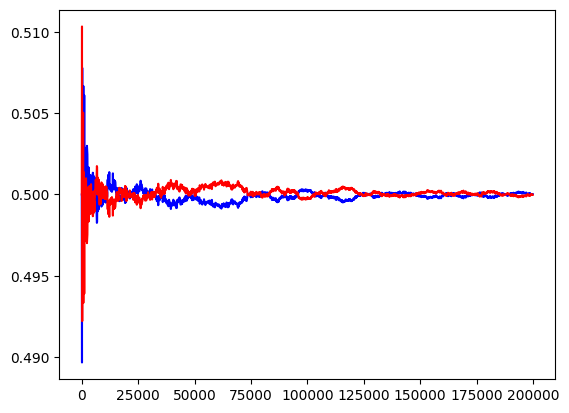

In [66]:
  
# my visualization of it hopefully converging 
abridgedmu0 = []
abridgedmu1 = []
for i in range(0, N, 100):
    abridgedmu0.append(mu[i][0])
    abridgedmu1.append(mu[i][1])

%matplotlib inline

plt.plot(list(range(0, N, 100)), abridgedmu0, 'b', label = "mean field control for ")
plt.plot(list(range(0, N, 100)), abridgedmu1, 'r')
plt.show()

10
